# Collect the dataset

Only need to do this once at the beginning.

In [4]:
%%bash
XENROOT="/build/hg/xen.git"
mkdir -p data
# Get all files checked into the Xen tree, *except* those in vgabios and rombios: those are
# much more like assembly than c.  Preserve the path by replacing '/' with '_'
for f in $(git -C $XENROOT ls-files "*.c" | grep -v bios/); do cp $XENROOT/$f data/${f//\//_}.c ; done

# Import the data

Define our dataset.  Note that we need to pad out all the samples in each batch to be the same length.

In [9]:
import torch
import glob
import string
import numpy as np
import pandas as pd

class Vocab():
    allchars = string.printable
    special=["UNK", # 'Unknown character' token
             "BOF", # 'Beginning of file' token
             "EOF", # 'End of file' token
             "PAD"] # 'Pad' token (shouldn't be processed)
    n_tokens = len(allchars) + len(special)

    def string_to_array(self, string):
        letter_indexes = []
        for li in range(len(string)):
            ci = self.allchars.find(string[li])
            if ci == -1:
                ci = self.UNK
            letter_indexes.append(ci)
        return letter_indexes
    
    def index_to_label(self, i):
        assert i < n_tokens
        if i < len(self.allchars):
            return self.allchars[i]
        i -= len(self.allchars)
        if i < len(special[i]):
            return self.special[i]

class CData():
    vocab = Vocab()
    
    # Dataframe columns:
    # file: name of file
    # rawtext: Unprocessed text of file
    # tensor_input/output: Raw text transformed to tensor by model

    def __init__(self, folder):
        self.df = pd.DataFrame(glob.glob(f"{folder}/*.c"), columns="file")
        print(f"{len(self.filenames)} sample files")
    
    def __getitem__(self, index):
        if self.items is None:
            file = open(self.filenames[index])
            try:
                data = file.read()
            except:
                print(f"Error processing file {self.filenames[index]}")
            finally:
                file.close()

            # Convert the file to straight letter indexes
            raw = self.vocab.string_to_array(data)

            # Input: BOF + file contents
            # Output: file contents + EOF
            # NB: Embedding() only accepts Long
            x = torch.LongTensor([self.vocab.BOF] + raw)
            y = torch.LongTensor(raw + [self.vocab.EOF])
            
            self.items[index] = (x, y)
        
        return self.items[index]
    
    # FIXME: Try grouping similar-sized files together
    def pad_collate(self, batch):
        # batch is an array of x/y tuples (where x and y are tensors)
        # Need to merge them into batch-sized padded X and Y tensors
        max_len = max([xy[0].shape[0] for xy in batch])
        #print(f"Padding to {max_len}")
        
        X = []
        Y = []
        
        for i, xy in enumerate(batch):
            (x, y) = xy
            assert x.size(0) == y.size(0), f"Size mismatch: x({x.size(0)}) and y({y.size(0)})"
            
            if x.size(0) < max_len:
                pad_size = list(x.shape)
                pad_size[0] = max_len - x.size(0)
                pad_tensor = torch.ones(*pad_size, dtype=torch.long) * self.vocab.PAD
                x = torch.cat([x, pad_tensor], dim=0)
                y = torch.cat([y, pad_tensor], dim=0)
            
            #print(f"Appending element of size {x.size(0)}")
            X.append(x)
            Y.append(y)

        return (torch.stack(X, 0), torch.stack(Y, 0))
    
    # Need to implement colate_fn to pad out individual elements
    def GetLoader(self, **kwargs):
        kwargs["collate_fn"]=self.pad_collate
        return DataLoader(self, **kwargs)
        
    def __len__(self):
        return len(self.filenames)        

And load the data from the file

In [10]:
DATA_FOLDER="data"
dataset = CData(DATA_FOLDER)

1002 sample files


# Define the model

In [13]:
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from time import time
from math import floor

class CLang(nn.Module):
    
    def __init__(self, dataset, hidden=128, embed_dim=10, layers=3, dropout=0.0):
        super(CLang, self).__init__()
        
        self.embed_dim = embed_dim
        self.lstm_hidden = hidden
        self.lstm_layers = layers
        self.dropout = dropout
        self.vocab = dataset.vocab
        
        # [Pipeline] batch x padded_length x 1
        # Embedding: Map characters to am "embedding" to make things easier
        self.embedding = nn.Embedding(self.vocab.n_letters,
                                      self.embed_dim, 
                                      padding_idx=self.vocab.PAD)
        
        # [Pipeline] batch x padded_length x embed_dim
        # LSTM: Predict output 
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.lstm_hidden,
                            num_layers = self.lstm_layers,
                            batch_first=True,
                            dropout=self.dropout)
        
        # [Pipeline] batch x padded_length x hidden_size
        
        # Decode the lstm cell output to predict the next character
        self.decoder = nn.Linear(self.lstm_hidden, self.vocab.n_letters)
        
        # [Pipeline] batch x padded_length x n_letters
        
        self.softmax = nn.LogSoftmax(dim=2)
        
        # [Pipeline] batch x padded_length x n_letters
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.lstm_layers, batch_size, self.lstm_hidden),
                torch.zeros(self.lstm_layers, batch_size, self.lstm_hidden))

    def forward(self, X, hidden):
        embedded = self.embedding(X)
        
        # TODO: pack / unpack batch.  Requires sorting batch by length.
        lstm_out, hidden = self.lstm(embedded, hidden)
        
        decoded = self.decoder(lstm_out)
        output = self.softmax(decoded)
        return output, hidden

In [14]:
crnn = CLang(dataset)
allloss = []

# Train the model

In [29]:
%matplotlib inline
from IPython.display import display, Code, Pretty
import matplotlib.pyplot as plt



def train_batch(model, batch, gclip=1.0):
    (X, Y) = batch
        
    assert X.size(0) == Y.size(0)
    batch_size = X.size(0)
        
    hidden = model.init_hidden(batch_size)
        
    #self.zero_grad()
    model.optimizer.zero_grad()
        
    output, hidden = model.forward(X, hidden)
    #Y_onehot = self.onehot(Y)
        
    # NLLLoss expects [seq, vocab, batch] and [seq, batch], so reshape output and Y to fit
    co = output.view(-1, model.dataset.n_letters, batch_size)
    cy = Y.view(-1, batch_size)
    #print(f"co {co.size()} cy {cy.size()}")
    loss = model.criterion(co, cy)
        
    loss.backward()
        
    # Not sure if this is the right place to do this...
    nn.utils.clip_grad_norm_(model.parameters(), gclip)
        
    model.optimizer.step()
        
    return loss.item()

def train(model, losses=[], iterations=5, batch_size=1, lr=0.01, max_code=200, statwindow=500):
    # FIXME: Figure out a better way to do this
    model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.criterion = nn.NLLLoss(ignore_index=model.vocab.PAD)

    bar = tqdm_notebook(range(iterations))
    loss = 0.0
    
    # Get an update-able code object
    fig,axis = plt.subplots(1,1)
    
    stats = display(Pretty(""), display_id=True)
    hist = display(fig, display_id=True)
    code = display(Code(""), display_id=True)

    loader = model.dataset.GetLoader(batch_size=batch_size, shuffle=True)
    loaderi = iter(loader)
    
    try:
        for i in bar:
            try:
                batch = next(loaderi)
            except:
                #print("Reloading dataset")
                loader = model.dataset.GetLoader(batch_size=batch_size, shuffle=True)
                loaderi = iter(loader)
                batch = next(loaderi)
            
            loss = train_batch(model, batch)
            
            losses.append(loss)

            prev = losses[-(2*statwindow):-(statwindow)]
            recent = losses[-(statwindow):]
            recent_mean = np.mean(recent)
            if len(prev) > 0:
                prev_mean = np.mean(prev)
                statstring = "%7d [%0.5f %0.5f %0.5f] [%0.5f %0.5f %0.5f] grad %0.5f" % (len(losses), min(recent), recent_mean, max(recent), min(prev), prev_mean, max(prev), recent_mean-prev_mean)
            else:
                statstring = "%7d [%0.5f %0.5f %0.5f]" % (len(losses), min(recent), recent_mean, max(recent))
            stats.update(Pretty(statstring))
            
            axis.clear()
            axis.hist(prev, 30)
            axis.hist(recent, 30)
            hist.update(fig)
            code.update(Code(generate(model, max_len=max_code), language="C"))

    except KeyboardInterrupt:
        pass
    
    plt.close()
    
    return losses

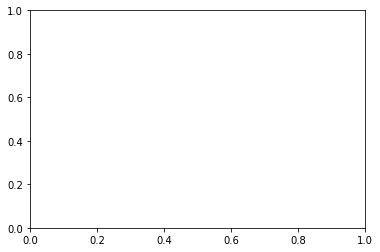

AttributeError: 'CLang' object has no attribute 'dataset'

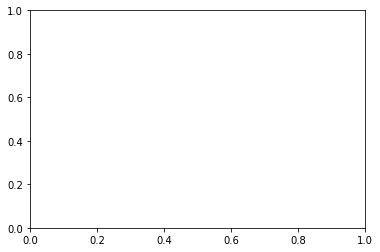

In [30]:
lastloss = train(crnn, losses=allloss, iterations=50000, batch_size=1, lr=0.0032, max_code=2000, statwindow=1010)

In [33]:
dataset.filenames[-10:]

['data/xen_xsm_flask_ss_ebitmap.c.c',
 'data/xen_xsm_flask_ss_hashtab.c.c',
 'data/xen_xsm_flask_ss_mls.c.c',
 'data/xen_xsm_flask_ss_policydb.c.c',
 'data/xen_xsm_flask_ss_services.c.c',
 'data/xen_xsm_flask_ss_sidtab.c.c',
 'data/xen_xsm_flask_ss_symtab.c.c',
 'data/xen_xsm_silo.c.c',
 'data/xen_xsm_xsm_core.c.c',
 'data/xen_xsm_xsm_policy.c.c']

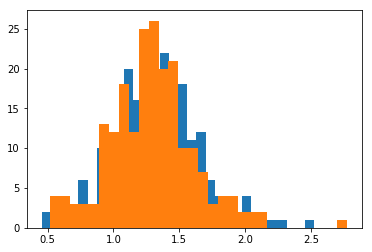

In [374]:
%matplotlib inline
import time

fig,ax = plt.subplots(1,1)

#hist = display(plt.gcf(), display_id=True)
hist = display(fig, display_id=True)

#plt.ion()

#fig.show()
#fig.canvas.draw()

window=int(len(allloss)/10)
for i in range(9):
    a=allloss[i*window:(i+1)*window]
    b=allloss[(i+1)*window:(i+2)*window]
    ax.clear()
    ax.hist(a, 30)
    ax.hist(b, 30)
#    fig.canvas.draw()
#    hist.update(plt.gcf())
    hist.update(fig)

    time.sleep(0.5)
    
plt.close()

In [265]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#%matplotlib notebook
# Can use 'inline' if notebook turns out to be unweildy
%matplotlib inline

def plot_loss(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss)
    if len(loss) > 50:
        window_length=len(loss)/10
        # window_length must be odd
        if (window_length % 2) == 0:
            window_length += 1
        llsmooth = savgol_filter(loss, 301, 3)
        plt.plot(llsmooth)
        


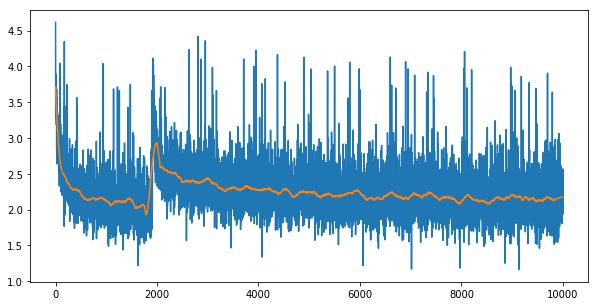

In [82]:
#plot_loss(allloss)
#llsmooth = savgol_filter(lastloss, 51, 3)
# Results for 10k iterations at 0.05 lr

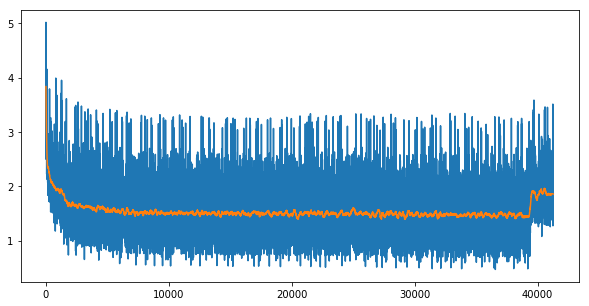

In [304]:
plot_loss(allloss)


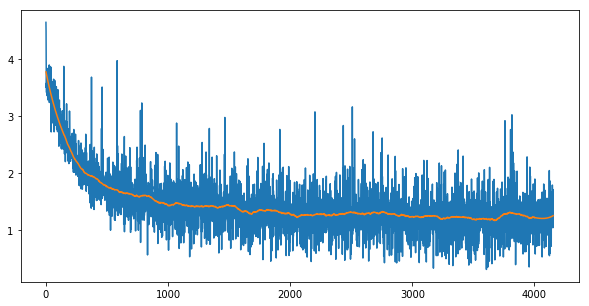

In [383]:
plot_loss(allloss)

Now play around with generation.

In [24]:
import random
import numpy as np

def generate(crnn, min_prob=0.03, max_len=1000):
    # Convert an index into a tensor
    def index_to_input(i):
        return torch.stack([torch.LongTensor([i])], 0)
    
    def weighted_index(weights):
        """ 
        weighted_choice selects a random element of 
        the sequence according to the list of weights
        """
        cum_weight = 0
        x = np.random.random() * sum(weights)
        for i, w in enumerate(weights):
            cum_weight += w
            if x < cum_weight:
                return i
        return len(weights)-1
    
    def weighted_square(weights):
        wsq = weights * weights
        return weighted_index(wsq)
    
    def min_prob_index(oprob):
        """
        min_prob_index filds all indexes with probability over min_prob and selects on of them
        (with equal probability)
        """
        indexes=[]
        chars=[]
        probs=[]
        for i, p in enumerate(oprob):
            if p > min_prob:
                indexes.append(i)
                if i < len(crnn.dataset.allchars):
                    chars.append(crnn.dataset.allchars[i])
                else:
                    chars.append(crnn.dataset.allchars.find('U'))
                probs.append(p)
        #print(indexes, chars, probs)
        assert len(indexes) > 0        
        return indexes[random.randint(0, len(indexes)-1)]
    
    def max_prob_index(oprob):
        return np.argmax(oprob)
    
    def max_or_weight(oprob, maxprob=0.5):
        if np.random.random() < maxprob:
            return max_prob_index(oprob)
        else:
            return weighted_square(oprob)
        
    def multinomial(oprob):
        return torch.multinomial(oprob, 1)[0]
    
    hidden = crnn.init_hidden(1)
    
    outstring=""
    
    # Manually run through the forward-iteration, chosing a new prediction
    nT = index_to_input(crnn.dataset.BOF)
    while True:
        # For some reason, no_grad() and eval() are separate...?
        with torch.no_grad():
            crnn.eval()
            output, hidden = crnn.forward(nT, hidden)
            crnn.train()
        
        # Convert log output to probability
        oprob = np.exp(output.view(-1))
        
        #nI = weighted_square(oprob)
        #nI = weighted_index(oprob)
        #nI = min_prob_index(oprob)
        #nI = max_prob_index(oprob)
        #nI = max_or_weight(oprob)
        nI = multinomial(oprob)


        if nI == crnn.dataset.EOF:
            break
            
        nC = -1

        if nI < len(crnn.dataset.allchars):
            nC = crnn.dataset.allchars[nI]
        else:
            # Theoretically should only be UNK, but there's always
            # a small possibility of PAD or BOF
            nC = "U"
        
        outstring += nC
        
        if len(outstring) >= max_len:
            break
        
        nT = index_to_input(nI)
        
    return outstring

In [389]:
s = generate(crnn, max_len=2000)
display(Code(s, language="C"))

/*
 * Cokep shutdown wakeuator mabaet through Xen there control to the call in bitmaps piddn'set.                       * a
 * e.nuvaction.  which cshonal
 * xenbl/'. Send, #MSD instable sis, the handler we do puble-line wbblichal bit not each.
 *
 * Copyright (C) 2006, ArveLaboul Vyd; xcs                 Xen a1. Firkdev HVM run C2ABLER, XENLOG: BEDM.
 * Nong alls */
#include <libmfnec.h>
#include <sys/stat.h>
#include <sys/arm-shared_conlines.
}
#_init_and_cty_var(xc_interface *xc)
{
	xc_hash_bmemory_cap_pree(file);
	fmap_str_t rnd;
	const struct term_argc[i] &= ALIP_HANDLE_sel;
	if (err)
		vicent = comproc_enument[0];

	return 0;

	return;
}

bool MS_SCOP_WIR_EF6 : { "dr: "copecess",
.disable = xenpmop_init(struct entry *puts)
{
	if(!acpi_disable_host) && (id++]) - last(s->blks, r22) == IRQNEPC_DEBUG) : "q"
		(sylmap))
		return -B = 0;
	count = rw->start
	utsc = tlp;

	struct rc sizeof(wetrasig, freq, end);
	if (size != 0 || off >= 0), &out)
		tmp_percpu[domain->num;
    n->i = pages;
}

static void compat_preq_unbarg(struct apei__get_max_interface-bit_t any,
		   _dec_cpuid_interface *daset,
	    (foreign_header.op_unplyg
struct do_domctl_port.u.confdomain *p, const int mems)
{
	char dr7asived;
}

int wisfinile_counorection_cstfn(length, int _physdev_data,
			const struct rv *ctx, name, const void *plg)
{
	list_do_sec(p, platform_mfn(physave[i].size >> Namid->entries++) >> 6);
	gwu_hap += 3;
	chain_irq_info(*expr);
	exit(0, PAGE_SIZE, 0, 0x001_06, ; head is file */
	kendect(val);
}

static void xen_buffer_page(struct vector *seargs, char *block, unsigned int symbols)
{
	vhd_stamy_errno = ACPI_OAX_LREK6;
	acpi_domain_print("Cappes. %%08x - ip.%b/addate %d\n", byte);
	ins320_80_1801820_i3 + 0x8L;
	rc = map[i].desc + 2;
	if (n) {
		msr_t currandlind_to_iommu_loadect(wostr);
		spin_lock = 0;
		t                     = -errno;
	if (rc = drimid->sngb_bwg_read_CPUIP_LOG_DOMID_APIC(1) ^
		{crent) {
	case PITDE_memoff_table:
	return node;
};


struct fil1_mli = {
	j = &pri

In [140]:
len(s)

1000